In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Vamos a ver las diferentes formas de calcular el omega bar

In [10]:
cm = np.loadtxt('/home/omarioni/Barras_GdGs/Barras_Gd/_data/new_phi_time.dat')
# cm = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd_/barras/new_phi_time.dat')
time = cm[:,1]
phi  = cm[:,2]

delta_t   = np.diff(time[::-1])
delta_phi = np.diff(phi[::-1])

tt = time[::-1][:-1]+delta_t/2.

veloc_ang = delta_phi/delta_t

In [6]:
1e9/3.086e16/3.17098e-8


1.0219051207939474

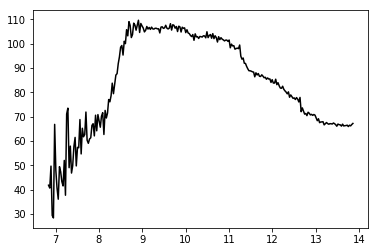

In [8]:
plt.plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')

In [11]:
vv = veloc_ang*2*np.pi/360.*1.0219051207939474
print vv[-1]

67.20898078845921


In [3]:
data = np.loadtxt('../_data/correcciones/lbar_time_GD.dat')
time_M31gd  = data[:,0]
lbar1_M31gd = data[:,1]
lbar2_M31gd = data[:,2]
lbar3_M31gd = data[:,3]
lbar4_M31gd = data[:,4]

data = np.loadtxt('../_data/correcciones/lbar_set_GS_001.dat')
time_M31gs  = data[:,0]
lbar1_M31gs = data[:,1]
lbar2_M31gs = data[:,2]
lbar3_M31gs = data[:,3]
lbar4_M31gs = data[:,4]

data = np.loadtxt('../_data/correcciones/lbar_set_GS_002.dat')
time_MWgs  = data[:,0]
lbar1_MWgs = data[:,1]
lbar2_MWgs = data[:,2]
lbar3_MWgs = data[:,3]
lbar4_MWgs = data[:,4]

In [4]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as tiempo
import barstrength2 as strng
import bines2 as bine
import scipy.interpolate as sint
from scipy.stats import mode
import tenform as ten
from matplotlib.ticker import MultipleLocator


#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

path0 = '/home/omarioni/'
atime = np.loadtxt(path0 + 'redshift_outputs.txt')
aexp = atime[:,2]

path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'



path = '/mnt/is2/alejandro/ornella/'
snapshot=range(496,300,-1)
k = 0
for isnap in snapshot:
    
    snap = h5py.File(path+'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
#     halos = (0,1,3)
    # for i in halos:
    j = 0
    cm   = snap['subhalo_'+ str('%03d' %j) + '/Center'][()]
    r200 = snap['subhalo_'+ str('%03d' %j) + '/R200'][()]

    pstr = snap['subhalo_'+ str('%03d' %j) + '/Str/Coordinates'][()]
    IDs  = snap['subhalo_'+ str('%03d' %j) + '/Str/Ids'][()]
    mstr = snap['subhalo_'+ str('%03d' %j) + '/Str/Masses'][()]
    vel  = snap['subhalo_'+ str('%03d' %j) + '/Str/Velocities'][()]

    pgas = snap['subhalo_'+ str('%03d' %j) + '/Gas/Coordinates'][()]
    mgas = snap['subhalo_'+ str('%03d' %j) + '/Gas/Masses'][()]

    pdrk = snap['subhalo_'+ str('%03d' %j) + '/Drk/Coordinates'][()]
    mdrk = snap['subhalo_'+ str('%03d' %j) + '/Drk/Masses'][()]

    z = a0/aexp[isnap] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time = tiempo.conv(z, h, omega_lambda, omega_matter)

    #---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
    ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
    zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
    ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
    zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

    #----------------------masas----------------------------
    mstr = mstr/h
    mgas = mgas/h
    mdrk = mdrk/h

    r200 = r200*aexp[isnap]/h
    rgal = 0.15*r200

    limit = np.where(rstr<rgal)
    r_sort = np.sort(rstr[limit])
    r_indice = np.argsort(rstr[limit])

    Mc_str = np.cumsum((mstr[limit])[r_indice])
    M_gal = Mc_str[-1]

    #------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    cincuenta, = np.where(razon < 0.5)

    r50 = r_sort[cincuenta][-1]              

    #------------------masa total en r200 (Mvir)--------------------------         
    veloc,=np.where(rstr<r50)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

    ##posiciones de partículas que se quiere graficar
    ##como lo de arriba me da los versores hago las posiciones con esto 

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    #------------------------------------------------------------------
    rtot = np.concatenate([rstr, rgas, rdrk])
    mtot = np.concatenate([mstr, mgas, mdrk])

    limit_tot   = np.where(rtot<r200)
    rtot_sort   = np.sort(rtot[limit_tot])
    rtot_indice = np.argsort(rtot[limit_tot])

    Mc_tot = np.cumsum((mtot[limit_tot])[rtot_indice])

    Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)


    #-----------------------------------------------------------------------
    #-----OMEGA BAR---------------------------------------------------------
    #-----------------------------------------------------------------------
    Rn = np.sqrt(xn**2 + yn**2)

    Vtg = (-yn*vxn + xn*vyn)/Rn

    omega = Vtg/Rn

    #-----Omega_bar 1---------------------------------------------------------

    mask_supreme, = np.where((Rn<3.*aexp[isnap]) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]))

    nbin=20
    med, nodos = bine.rbin1(Rn[mask_supreme],nbin)

    omega_mean   = np.zeros(nbin)

    for i in range(0,nbin):
        mask, = np.where((Rn[mask_supreme] > nodos[i]) & (Rn[mask_supreme] < nodos[i+1]))

        omega_mean[i] = np.mean(omega[mask_supreme][mask])

    finterp1 = sint.interp1d(med,omega_mean,fill_value="extrapolate")
    
#     if lbar2_M31gd[k] == np.nan:
#         omegabar21 = np.nan
#     else:
#         omegabar21 = finterp1(lbar2_M31gd[k])
        
    omegabar11 = finterp1(lbar1_M31gd[k])
    omegabar21 = finterp1(lbar2_M31gd[k])
    omegabar31 = finterp1(lbar3_M31gd[k])
    omegabar41 = finterp1(lbar4_M31gd[k])

#     print 'omega_bar11 = ', omegabar11
#     print 'omega_bar21 = ', omegabar21
#     print 'omega_bar31 = ', omegabar31
#     print 'omega_bar41 = ', omegabar41


    #-----Omega_bar 2---------------------------------------------------------

    Rn = np.sqrt(xn**2 + yn**2)
    rn = np.sqrt(xn**2 + yn**2 + zn**2)
    Vtg = (-yn*vxn + xn*vyn)/Rn

    omega = Vtg/Rn

    mask_s2 = np.where(rn < 3*aexp[isnap])

    nbin=20
    med, nodos = bine.rbin1(rn[mask_s2],nbin)

    omega_mean   = np.zeros(nbin)

    for i in range(0,nbin):
        mask, = np.where((rn[mask_s2] > nodos[i]) & (rn[mask_s2] < nodos[i+1]))

        omega_mean[i] = np.mean(omega[mask_s2][mask])

    finterp2 = sint.interp1d(med,omega_mean,fill_value="extrapolate")
    
#     if lbar2_M31gd[k] == np.nan:
#         omegabar22 = np.nan
#     else:
#         omegabar22 = finterp2(lbar2_M31gd[k])
        
    omegabar12 = finterp2(lbar1_M31gd[k])
    omegabar22 = finterp2(lbar2_M31gd[k])
    omegabar32 = finterp2(lbar3_M31gd[k])
    omegabar42 = finterp2(lbar4_M31gd[k])

#     print 'omega_bar12 = ', omegabar12
#     print 'omega_bar22 = ', omegabar22
#     print 'omega_bar32 = ', omegabar32
#     print 'omega_bar42 = ', omegabar42

    #-----Omega_bar 3---------------------------------------------------------
    corte2, = np.where(rn<3.*aexp[isnap])
    A2max, rmax, phimax = strng.a2max(mstr[corte2], xn[corte2], yn[corte2], 20)

    xx = xn* np.cos(phimax) + yn*np.sin(phimax)
    yy = xn*-np.sin(phimax) + yn*np.cos(phimax)
    zz = zn

    rr = np.sqrt(xx**2 + yy**2 + zz**2)
    
        
    limit1,=np.where(rr < lbar1_M31gd[k])
#     limit2,=np.where(rr < lbar2_M31gd[k])
#     limit3,=np.where(rr < lbar3_M31gd[k])
#     limit4,=np.where(rr < lbar4_M31gd[k])

    tensor1 = ten.tenf(xx[limit1], yy[limit1], zz[limit1])
#     tensor2 = ten.tenf(xx[limit2], yy[limit2], zz[limit2])
#     tensor3 = ten.tenf(xx[limit3], yy[limit3], zz[limit3])
#     tensor4 = ten.tenf(xx[limit4], yy[limit4], zz[limit4])

    matriz1 = np.linalg.eig(tensor1)
#     matriz2 = np.linalg.eig(tensor2)
#     matriz3 = np.linalg.eig(tensor3)
#     matriz4 = np.linalg.eig(tensor4)

    autov1  = matriz1[0]
#     autov2  = matriz2[0]
#     autov3  = matriz3[0]
#     autov4  = matriz4[0]

    asort1  = np.sort(autov1)
#     asort2  = np.sort(autov2)
#     asort3  = np.sort(autov3)
#     asort4  = np.sort(autov4)

    A1 = np.sqrt(asort1[2])
    B1 = np.sqrt(asort1[1])
    C1 = np.sqrt(asort1[0])

#     A2 = np.sqrt(asort2[2])
#     B2 = np.sqrt(asort2[1])
#     C2 = np.sqrt(asort2[0])

#     A3 = np.sqrt(asort3[2])
#     B3 = np.sqrt(asort3[1])
#     C3 = np.sqrt(asort3[0])

#     A4 = np.sqrt(asort4[2])
#     B4 = np.sqrt(asort4[1])
#     C4 = np.sqrt(asort4[0])


    #Definimos el tamaño de nuestro elipsoide
    aa=lbar1_M31gd[k]
    bb=(B1/A1)*lbar1_M31gd[k]
    cc=(C1/A1)*lbar1_M31gd[k]

#     print 'a=', aa, 'b=', bb, 'c=', cc

    RR = np.sqrt((xx/aa)**2+(yy/bb)**2+(zz/cc)**2) # formula del elipsoide
    mask, = np.where(RR<=1.) #seleccionamos las particulas dentro del elipsoide

    xn1   = xn[mask]
    yn1   = yn[mask]
    zn1   = zn[mask]
    vxn1  = vxn[mask]
    vyn1  = vyn[mask]
    vzn1  = vzn[mask]
    mstr1 = mstr[mask]


    rn1 = np.sqrt(xn1**2 + yn1**2 + zn1**2)
    Rn1 = np.sqrt(xn1**2 + yn1**2)

    Vtg = (-yn1*vxn1 + xn1*vyn1)/Rn1

    omega = Vtg/Rn1

    nbin=20
    med, nodos= bine.rbin1(rn1,nbin)

    omega_mean   = np.zeros(nbin)

    for i in range(0,nbin):
        mask, = np.where((rn1 > nodos[i]) & (rn1 < nodos[i+1]))

        omega_mean[i] = np.mean(omega[mask])

    finterp3 = sint.interp1d(med,omega_mean,fill_value="extrapolate")

#     if lbar2_M31gd[k] == np.nan:
#         omegabar23 = np.nan
#     else:
#         omegabar23 = finterp3(lbar2_M31gd[k])
        
    omegabar13 = finterp3(lbar1_M31gd[k])
    omegabar23 = finterp3(lbar2_M31gd[k])
    omegabar33 = finterp3(lbar3_M31gd[k])
    omegabar43 = finterp3(lbar4_M31gd[k])

#     print 'omega_bar13 = ', omegabar13
#     print 'omega_bar23 = ', omegabar23
#     print 'omega_bar33 = ', omegabar33
#     print 'omega_bar43 = ', omegabar43

    
    #-----------------------------------------------------------------------
    #---- Rcorot -----------------------------------------------------------
    #-----------------------------------------------------------------------

    omega_circ= Vtot/rtot_sort

    interp  = sint.interp1d(omega_circ,rtot_sort,fill_value="extrapolate")
    
#     if omegabar21 == np.nan:
#         rcorot21 = np.nan
#     else:
#         rcorot21 = interp(omegabar21)
    
    rcorot11 = interp(omegabar11)
    rcorot21 = interp(omegabar21)
    rcorot31 = interp(omegabar31)
    rcorot41 = interp(omegabar41)

#     print 'Rcorot11 = ', rcorot11
#     print 'Rcorot21 = ', rcorot21
#     print 'Rcorot31 = ', rcorot31
#     print 'Rcorot41 = ', rcorot41

#     if omegabar22 == np.nan:
#         rcorot22 = np.nan
#     else:
#         rcorot22 = interp(omegabar22)
        
    rcorot12 = interp(omegabar12)
    rcorot22 = interp(omegabar22)
    rcorot32 = interp(omegabar32)
    rcorot42 = interp(omegabar42)

#     print 'Rcorot12 = ', rcorot12
#     print 'Rcorot22 = ', rcorot22
#     print 'Rcorot32 = ', rcorot32
#     print 'Rcorot42 = ', rcorot42

#     if omegabar23 == np.nan:
#         rcorot23 = np.nan
#     else:
#         rcorot23 = interp(omegabar23)
        
    rcorot13 = interp(omegabar13)
    rcorot23 = interp(omegabar23)
    rcorot33 = interp(omegabar33)
    rcorot43 = interp(omegabar43)

#     print 'Rcorot13 = ', rcorot13
#     print 'Rcorot23 = ', rcorot23
#     print 'Rcorot33 = ', rcorot33
#     print 'Rcorot43 = ', rcorot43

    archivo = open(path2 + 'omega_time_GD.dat','a')
    archivo.write(str('%12.8f'% time) +'\t'+
                str('%12.8f'% omegabar11) +'\t'+
                str('%12.8f'% omegabar21) +'\t'+
                str('%12.8f'% omegabar31) +'\t'+
                str('%12.8f'% omegabar41) +'\t'+
                str('%12.8f'% omegabar12) +'\t'+
                str('%12.8f'% omegabar22) +'\t'+
                str('%12.8f'% omegabar32) +'\t'+
                str('%12.8f'% omegabar42) +'\t'+
                str('%12.8f'% omegabar13) +'\t'+
                str('%12.8f'% omegabar23) +'\t'+
                str('%12.8f'% omegabar33) +'\t'+
                str('%12.8f'% omegabar43) +'\n')
    archivo.close()
    
    archivo2 = open(path2 + 'rcorot_time_GD.dat','a')
    archivo2.write( str('%12.8f'% time) +'\t'+
                   str('%12.8f'% rcorot11) +'\t'+
                   str('%12.8f'% rcorot21) +'\t'+
                   str('%12.8f'% rcorot31) +'\t'+
                   str('%12.8f'% rcorot41) +'\t'+
                   str('%12.8f'% rcorot12) +'\t'+
                   str('%12.8f'% rcorot22) +'\t'+
                   str('%12.8f'% rcorot32) +'\t'+
                   str('%12.8f'% rcorot42) +'\t'+
                   str('%12.8f'% rcorot13) +'\t'+
                   str('%12.8f'% rcorot23) +'\t'+
                   str('%12.8f'% rcorot33) +'\t'+
                   str('%12.8f'% rcorot43) +'\n')
    archivo2.close()
    k=k+1


/home/omarioni/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in divide
/home/omarioni/miniconda2/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/omarioni/miniconda2/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


IndexError: index 193 is out of bounds for axis 0 with size 193

In [12]:
path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'

GADGET = np.loadtxt(path+'omega_time_GD.dat')
time    = GADGET[:,0]
omega11 = GADGET[:,1]
omega21 = GADGET[:,2]
omega31 = GADGET[:,3]
omega41 = GADGET[:,4]
omega12 = GADGET[:,5]
omega22 = GADGET[:,6]
omega32 = GADGET[:,7]
omega42 = GADGET[:,8]
omega13 = GADGET[:,9]
omega23 = GADGET[:,10]
omega33 = GADGET[:,11]
omega43 = GADGET[:,12]


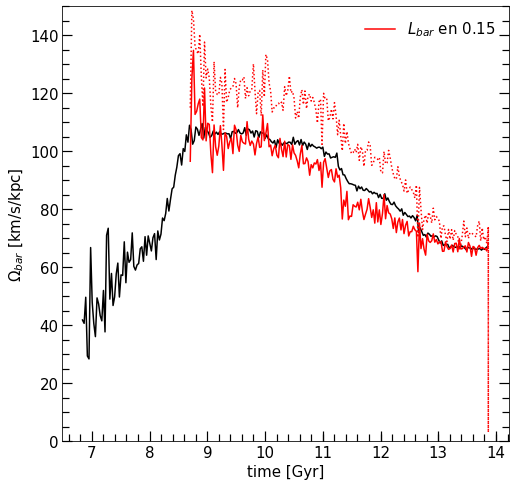

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), sharex=True)
#                        gridspec_kw = {'height_ratios':[2,5]})
# fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)
ax.plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
ax.plot(time,omega11, color='r', label='$L_{bar}$ en 0.15')
# ax.plot(time,omega21, color='g',label='$L_{bar}$ usando $\phi(R)$')
# ax.plot(time,omega31, color='b',label='$L_{bar}$ en 0.25*$A_2^{max}$')
# ax.plot(time,omega41, color='darkorange',label='$L_{bar}$ usando perfiles x,y')
# ax.plot(time,omega12, color='r', ls='--')
# ax.plot(time,omega22, color='g', ls='--')
# ax.plot(time,omega32, color='b', ls='--')
# ax.plot(time,omega42, color='darkorange', ls='--')
ax.plot(time,omega13, color='r', ls=':')
# ax.plot(time,omega23, color='g', ls=':')
# ax.plot(time,omega33, color='b', ls=':')
# ax.plot(time,omega43, color='darkorange', ls=':')
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax.set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
ax.set_xlabel('time [Gyr]',fontsize=15)
ax.set_ylim(0,150)
ax.legend(fontsize=15,frameon=False)

In [2]:
path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'

GADGET = np.loadtxt(path+'lbar_set_GD.dat')
M31gd_lbar1 = GADGET[0,1]
M31gd_lbar2 = GADGET[0,2]
M31gd_lbar3 = GADGET[0,3]
M31gd_lbar4 = GADGET[0,4]

GASOLINE = np.loadtxt(path+'lbar_set_GS.dat')
M31gs_lbar1 = GASOLINE[0,1]
M31gs_lbar2 = GASOLINE[0,2]
M31gs_lbar3 = GASOLINE[0,3]
M31gs_lbar4 = GASOLINE[0,4]

MWgs_lbar1 = GASOLINE[1,1]
MWgs_lbar2 = GASOLINE[1,2]
MWgs_lbar3 = GASOLINE[1,3]
MWgs_lbar4 = GASOLINE[1,4]

In [50]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as tiempo
import barstrength2 as strng
import bines2 as bine
import scipy.interpolate as sint
from scipy.stats import mode
import tenform as ten
from matplotlib.ticker import MultipleLocator


#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

path0 = '/home/omarioni/'
atime = np.loadtxt(path0 + 'redshift_outputs.txt')
aexp = atime[:,2]

path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
# archivo = open(path2 + 'omega_set_GD.dat','a')


path = '/mnt/is2/alejandro/ornella/'
# snapshot=range(496,300,-1)
# for isnap in snapshot:

isnap = 496
snap = h5py.File(path+'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
halos = (0,1,3)

# for i in halos:
i = 0
cm   = snap['subhalo_'+ str('%03d' %i) + '/Center'][()]
r200 = snap['subhalo_'+ str('%03d' %i) + '/R200'][()]

pstr = snap['subhalo_'+ str('%03d' %i) + '/Str/Coordinates'][()]
IDs  = snap['subhalo_'+ str('%03d' %i) + '/Str/Ids'][()]
mstr = snap['subhalo_'+ str('%03d' %i) + '/Str/Masses'][()]
vel  = snap['subhalo_'+ str('%03d' %i) + '/Str/Velocities'][()]

pgas = snap['subhalo_'+ str('%03d' %i) + '/Gas/Coordinates'][()]
mgas = snap['subhalo_'+ str('%03d' %i) + '/Gas/Masses'][()]

pdrk = snap['subhalo_'+ str('%03d' %i) + '/Drk/Coordinates'][()]
mdrk = snap['subhalo_'+ str('%03d' %i) + '/Drk/Masses'][()]

z = a0/aexp[isnap] - 1.
Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
# time = tiempo.conv(z, h, omega_lambda, omega_matter)

#---aca paso las coordenadas respecto al centro de la galaxia------
xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

#----------------------masas----------------------------
mstr = mstr/h
mgas = mgas/h
mdrk = mdrk/h

r200 = r200*aexp[isnap]/h
rgal = 0.15*r200

limit = np.where(rstr<rgal)
r_sort = np.sort(rstr[limit])
r_indice = np.argsort(rstr[limit])

Mc_str = np.cumsum((mstr[limit])[r_indice])
M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
razon = Mc_str/M_gal
cincuenta, = np.where(razon < 0.5)

r50 = r_sort[cincuenta][-1]              

#------------------masa total en r200 (Mvir)--------------------------         
veloc,=np.where(rstr<r50)

#----------componentes de la velocidad del centro de masa------------
vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
vx = v_x - vxcm
vy = v_y - vycm
vz = v_z - vzcm

e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

xn = e1x*xstr + e1y*ystr + e1z*zstr
yn = e2x*xstr + e2y*ystr + e2z*zstr
zn = e3x*xstr + e3y*ystr + e3z*zstr
vxn = e1x*vx + e1y*vy + e1z*vz
vyn = e2x*vx + e2y*vy + e2z*vz
vzn = e3x*vx + e3y*vy + e3z*vz

#------------------------------------------------------------------
rtot = np.concatenate([rstr, rgas, rdrk])
mtot = np.concatenate([mstr, mgas, mdrk])

limit_tot   = np.where(rtot<r200)
rtot_sort   = np.sort(rtot[limit_tot])
rtot_indice = np.argsort(rtot[limit_tot])

Mc_tot = np.cumsum((mtot[limit_tot])[rtot_indice])

Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)


print 'lbar1 = ', M31gd_lbar1
print 'lbar2 = ', M31gd_lbar2
print 'lbar3 = ', M31gd_lbar3
print 'lbar4 = ', M31gd_lbar4


#-----------------------------------------------------------------------
#-----OMEGA BAR---------------------------------------------------------
#-----------------------------------------------------------------------
Rn = np.sqrt(xn**2 + yn**2)

Vtg = (-yn*vxn + xn*vyn)/Rn

omega = Vtg/Rn

#-----Omega_bar 1---------------------------------------------------------

mask_supreme, = np.where((Rn<3.*aexp[isnap]) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]))

nbin=20
med, nodos = bine.rbin1(Rn[mask_supreme],nbin)

omega_mean   = np.zeros(nbin)

for i in range(0,nbin):
    mask, = np.where((Rn[mask_supreme] > nodos[i]) & (Rn[mask_supreme] < nodos[i+1]))

    omega_mean[i] = np.mean(omega[mask_supreme][mask])

finterp1 = sint.interp1d(med,omega_mean,fill_value="extrapolate")

omegabar11 = finterp1(M31gd_lbar1)
omegabar21 = finterp1(M31gd_lbar2)
omegabar31 = finterp1(M31gd_lbar3)
omegabar41 = finterp1(M31gd_lbar4)

print 'omega_bar11 = ', omegabar11
print 'omega_bar21 = ', omegabar21
print 'omega_bar31 = ', omegabar31
print 'omega_bar41 = ', omegabar41


#-----Omega_bar 2---------------------------------------------------------

Rn = np.sqrt(xn**2 + yn**2)
rn = np.sqrt(xn**2 + yn**2 + zn**2)
Vtg = (-yn*vxn + xn*vyn)/Rn

omega = Vtg/Rn

mask_s2 = np.where(rn < 3*aexp[isnap])

nbin=20
med, nodos = bine.rbin1(rn[mask_s2],nbin)

omega_mean   = np.zeros(nbin)

for i in range(0,nbin):
    mask, = np.where((rn[mask_s2] > nodos[i]) & (rn[mask_s2] < nodos[i+1]))

    omega_mean[i] = np.mean(omega[mask_s2][mask])

finterp2 = sint.interp1d(med,omega_mean,fill_value="extrapolate")

omegabar12 = finterp2(M31gd_lbar1)
omegabar22 = finterp2(M31gd_lbar2)
omegabar32 = finterp2(M31gd_lbar3)
omegabar42 = finterp2(M31gd_lbar4)

print 'omega_bar12 = ', omegabar12
print 'omega_bar22 = ', omegabar22
print 'omega_bar32 = ', omegabar32
print 'omega_bar42 = ', omegabar42

#-----Omega_bar 3---------------------------------------------------------
corte2, = np.where(rn<6.)
A2, phi, rbin = strng.a2(mstr[corte2], xn[corte2], yn[corte2], 20)
A2max, rmax, phimax = strng.a2max(mstr[corte2], xn[corte2], yn[corte2], 20)

xx = xn* np.cos(phimax) + yn*np.sin(phimax)
yy = xn*-np.sin(phimax) + yn*np.cos(phimax)
zz = zn

rr = np.sqrt(xx**2 + yy**2 + zz**2)

limit1,=np.where(rr < M31gd_lbar1)
limit2,=np.where(rr < M31gd_lbar2)
limit3,=np.where(rr < M31gd_lbar3)
limit4,=np.where(rr < M31gd_lbar4)

tensor1 = ten.tenf(xx[limit1], yy[limit1], zz[limit1])
tensor2 = ten.tenf(xx[limit2], yy[limit2], zz[limit2])
tensor3 = ten.tenf(xx[limit3], yy[limit3], zz[limit3])
tensor4 = ten.tenf(xx[limit4], yy[limit4], zz[limit4])

matriz1 = np.linalg.eig(tensor1)
matriz2 = np.linalg.eig(tensor2)
matriz3 = np.linalg.eig(tensor3)
matriz4 = np.linalg.eig(tensor4)

autov1  = matriz1[0]
autov2  = matriz2[0]
autov3  = matriz3[0]
autov4  = matriz4[0]

asort1  = np.sort(autov1)
asort2  = np.sort(autov2)
asort3  = np.sort(autov3)
asort4  = np.sort(autov4)

A1 = np.sqrt(asort1[2])
B1 = np.sqrt(asort1[1])
C1 = np.sqrt(asort1[0])

A2 = np.sqrt(asort2[2])
B2 = np.sqrt(asort2[1])
C2 = np.sqrt(asort2[0])

A3 = np.sqrt(asort3[2])
B3 = np.sqrt(asort3[1])
C3 = np.sqrt(asort3[0])

A4 = np.sqrt(asort4[2])
B4 = np.sqrt(asort4[1])
C4 = np.sqrt(asort4[0])


#Definimos el tamaño de nuestro elipsoide
aa=M31gd_lbar1
bb=(B1/A1)*M31gd_lbar1
cc=(C1/A1)*M31gd_lbar1

print 'a=', aa, 'b=', bb, 'c=', cc

RR = np.sqrt((xx/aa)**2+(yy/bb)**2+(zz/cc)**2) # formula del elipsoide
mask, = np.where(RR<=1.) #seleccionamos las particulas dentro del elipsoide

xn1   = xn[mask]
yn1   = yn[mask]
zn1   = zn[mask]
vxn1  = vxn[mask]
vyn1  = vyn[mask]
vzn1  = vzn[mask]
mstr1 = mstr[mask]


rn1 = np.sqrt(xn1**2 + yn1**2 + zn1**2)
Rn1 = np.sqrt(xn1**2 + yn1**2)

Vtg = (-yn1*vxn1 + xn1*vyn1)/Rn1

omega = Vtg/Rn1

nbin=20
med, nodos = bine.rbin1(rn1,nbin)

omega_mean   = np.zeros(nbin)

for i in range(0,nbin):
    mask, = np.where((rn1 > nodos[i]) & (rn1 < nodos[i+1]))

    omega_mean[i] = np.mean(omega[mask])

finterp3 = sint.interp1d(med,omega_mean,fill_value="extrapolate")

omegabar13 = finterp3(M31gd_lbar1)
omegabar23 = finterp3(M31gd_lbar2)
omegabar33 = finterp3(M31gd_lbar3)
omegabar43 = finterp3(M31gd_lbar4)

print 'omega_bar13 = ', omegabar13
print 'omega_bar23 = ', omegabar23
print 'omega_bar33 = ', omegabar33
print 'omega_bar43 = ', omegabar43


#-----------------------------------------------------------------------
#---- Rcorot -----------------------------------------------------------
#-----------------------------------------------------------------------

omega_circ= Vtot/rtot_sort

interp  = sint.interp1d(omega_circ,rtot_sort,fill_value="extrapolate")
rcorot11 = interp(omegabar11)
rcorot21 = interp(omegabar21)
rcorot31 = interp(omegabar31)
rcorot41 = interp(omegabar41)

print 'Rcorot11 = ', rcorot11
print 'Rcorot21 = ', rcorot21
print 'Rcorot31 = ', rcorot31
print 'Rcorot41 = ', rcorot41


rcorot12 = interp(omegabar12)
rcorot22 = interp(omegabar22)
rcorot32 = interp(omegabar32)
rcorot42 = interp(omegabar42)

print 'Rcorot12 = ', rcorot12
print 'Rcorot22 = ', rcorot22
print 'Rcorot32 = ', rcorot32
print 'Rcorot42 = ', rcorot42


rcorot13 = interp(omegabar13)
rcorot23 = interp(omegabar23)
rcorot33 = interp(omegabar33)
rcorot43 = interp(omegabar43)

print 'Rcorot13 = ', rcorot13
print 'Rcorot23 = ', rcorot23
print 'Rcorot33 = ', rcorot33
print 'Rcorot43 = ', rcorot43




 lbar1 =  1.39349555
lbar2 =  1.93602766
lbar3 =  1.54469302
lbar4 =  2.39031181
omega_bar11 =  68.497815369299
omega_bar21 =  52.12183176325099
omega_bar31 =  63.426405781818
omega_bar41 =  41.73895261819226
omega_bar12 =  62.65947114487613
omega_bar22 =  44.80298334273375
omega_bar32 =  56.89482446391624
omega_bar42 =  34.41768521685631
a= 1.39349555 b= 0.965279422941713 c= 0.7512662527927515
omega_bar12 =  73.44770032451375
omega_bar22 =  56.17874387588608
omega_bar32 =  68.63504043499552
omega_bar42 =  41.71874591990917
Rcorot11 =  2.2062676814548907
Rcorot21 =  2.7778262682808514
Rcorot31 =  2.35368532951466
Rcorot41 =  3.3482996310965767
Rcorot12 =  2.378067277873556
Rcorot22 =  3.1543495005543605
Rcorot32 =  2.5792837951544816
Rcorot42 =  3.9473871927822937
Rcorot13 =  2.080325158980639
Rcorot23 =  2.607199483442995
Rcorot33 =  2.2025625142575582
Rcorot43 =  3.3498371243710796


In [33]:
aa=M31gd_lbar4
bb=(B4/A4)*M31gd_lbar4
cc=(C4/A4)*M31gd_lbar4

print 'a=', aa, 'b=', bb, 'c=', cc

a= 2.39031181 b= 2.0369029287266756 c= 1.4925657600231037


In [22]:
print A1,B1,C1, B1/A1, C1/A1

0.5043703801684629 0.3493791921458998 0.27191794443033324 0.6927036278958429 0.5391235392124155


In [23]:
print A2,B2,C2, B2/A2, C2/A2

0.6021476514735804 0.47171367276768716 0.3533791468813856 0.7833853899675699 0.5868646103934698


In [24]:
print A3,B3,C3, B3/A3, C3/A3

0.5324979087801163 0.3822418161285958 0.2930245086276692 0.7178278258486729 0.5502829284324334


In [25]:
print A4,B4,C4, B4/A4, C4/A4

0.6884607498727467 0.5866714592893054 0.42989075236167285 0.8521494644360542 0.6244230371028889


In [34]:
RR = np.sqrt((xx/aa)**2+(yy/bb)**2+(zz/cc)**2) # formula del elipsoide
mask, = np.where(RR<=1.) #seleccionamos las particulas dentro del elipsoide

xn1   = xn[mask]
yn1   = yn[mask]
zn1   = zn[mask]


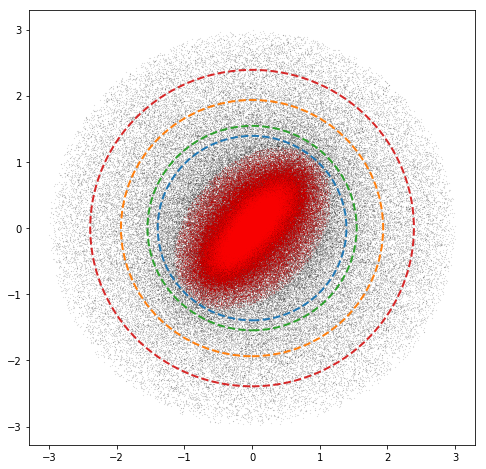

In [52]:
import matplotlib.patches as patches
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), sharex=True)
# fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

ax.plot(xn[np.where(rn<3.)],yn[np.where(rn<3.)],'.k',markersize=0.1)
ax.plot(xn1,yn1,'.r',markersize=0.1)
circ1 = patches.Circle((0., 0.), M31gd_lbar1, fc='None',ec='tab:blue',ls='--',lw=2,zorder=10)
circ2 = patches.Circle((0., 0.), M31gd_lbar2, fc='None',ec='tab:orange',ls='--',lw=2,zorder=10)
circ3 = patches.Circle((0., 0.), M31gd_lbar3, fc='None',ec='tab:green',ls='--',lw=2,zorder=10)
circ4 = patches.Circle((0., 0.), M31gd_lbar4, fc='None',ec='tab:red',ls='--',lw=2,zorder=10)
ax.add_patch(circ1)
ax.add_patch(circ2)
ax.add_patch(circ3)
ax.add_patch(circ4)